# Clustering using competitive learning (without dead unit handling)

In [ ]:
import numpy as np
import numpy.matlib
import math
import DC_Pickle as dcp
import matplotlib.pyplot as plt

train_scores = dcp.open_Pickle('../../data/pickles/seperate_test/eventValue.pickle')
train_scores = train_scores[:15, :]

train_data = np.ones(15)*np.nan
idx_data = []

for i in range(train_scores.shape[1]):
    if not np.isnan(train_scores[:, i]).any():
        train_data = np.vstack((train_data, train_scores[:, i]))
        idx_data.append(i)
        
train_data = np.delete(train_data, (0), axis=0) # delete the first row including nan
train_data = train_data.T

[n,m]  = np.shape(train_data)               # dimension and number of training data

eta    = 0.05                               # learning rate
winit  = 1                                  # initialise weight

tmax   = 40000                              # max learning iteration

print(" - Dimension: {0}\n - Individuals: {1}".format(n, m))

fig_stats, axes_stats = plt.subplots(2,1)   # fig for the learning stats

## function for clustering with cost function return
def get_Cost(clusters_num, train):
    costs = []
    centroids = np.zeros((clusters_num, n, 10), dtype=float)
    cluster_idx = np.ones((10, m))*np.nan # 2X2 matrix to save all cluster index for each data
    
    for iter_i in range(10):
        W = winit * np.random.rand(clusters_num,n)        # Weight matrix (rows = output neurons, cols = input neurons)
        normW = np.sqrt(np.diag(W.dot(W.T)))
        normW = normW.reshape(clusters_num,-1)            # reshape normW into a numpy 2d array
        W = W / normW                               # normalise using numpy broadcasting

        normTrain = np.sqrt(np.diag(np.dot(train.T, train)))
        normTrain = normTrain.reshape(m, -1)
        train = train/normTrain.T

        counter = np.zeros((1,clusters_num))              # counter for the winner neurons
        wCount = np.ones((1,tmax+1)) * 0.25         # running avg of the weight change over time
        alpha = 0.999

        yl = int(round(clusters_num/5))                   # counter for the rows of the subplot
        if clusters_num % 5 != 0:
            yl += 1

        for t in range(1,tmax):
            i = math.ceil(m * np.random.rand())-1   # get a randomly generated index in the input range
            x = train[:,i]                          # pick a training instance using the random index

            h = W.dot(x)/clusters_num                     # get output firing
            h = h.reshape((h.shape[0],-1))          # reshape h into a numpy 2d array
            k = np.argmax(h)                     # get the index of the firing neuron

            counter[0,k] += 1                       # increment counter for winner neuron

            dw = eta * (x.T - W[k,:])               # calculate the change in weights for the k-th output neuron

            wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # % weight change over time (running avg)

            W[k,:] = W[k,:] + dw                    # weights for k-th output are updated

            if wCount[0, t] < 0.0001: # if it learns sufficiently with learning rate below 0.0001
                break

        ##########################################
        ## save means of clusters into the 3X3 centroids matrix
        centroids[:, :, iter_i] = W

        ##########################################
        # cluster_idx : 2X2 matrix to save all cluster index for each data
        ##########################################
        ## get indices of clusters for each data
        for data in range(m): # check all data
            min_vals = []
            for weight in range(clusters_num): # compare all clusters for a data
                diff = W[weight, :] - train[:, data] # get difference between data and clusters
                min_vals.append(sum(np.square(diff))) # get square distance

            min_idx = np.argmin(min_vals) # get cluster index which has minimum distance
            cluster_idx[iter_i, data] = min_idx # assign the index to the cluster_idx array

        # assign True and False if data belongs to specific cluster.
        for i in range(clusters_num):
            cluster_map = cluster_idx[iter_i, :] == i

            # make True and False matrix (cluster) for mapping
            cluster = cluster_map
            for j in range(14):
                cluster = np.vstack((cluster, cluster_map))
            #print(np.shape(train[cluster].reshape(n, -1)))

            for k in range(clusters_num):
                clt = "cluster{0}".format(i+1)
                globals()[clt]=train[cluster].reshape(n, -1)
            #print("cluster{0}: ".format(i), np.shape(eval("cluster{0}".format(i))))

        ##########################################
        ## Get average cost function of 10 iterations
        diff_sum = [] # all differences of clusters
        for c in range(clusters_num):
            diff_vals = [] # difference for one cluster
            clt = "cluster{0}".format(c+1)
            [n2, m2] = np.shape(eval(clt))
            for data in range(m2):
                diff = np.square(eval(clt)[:, data] - W[c, :])
                diff_vals.append(np.sum(diff))

            diff_sum.append(np.sum(diff_vals))

        costs.append(np.sum(diff_sum))
        
        # average of weight changes in time
        axes_stats[0].clear()
        axes_stats[0].set_title("Weight change in time")
        axes_stats[0].semilogx(wCount[0, 2:t + 1], '-b', linewidth=2.0)     # range of 2:t+1 is 3 ~ t+1
        axes_stats[0].set_xlim([1, 4*10000])
        axes_stats[0].set_ylim([-0.001, 0.255])
        
        # plot the number of output neurons' firing
        axes_stats[1].clear()
        axes_stats[1].set_title("Ouput neurons' entire firing number")
        axes_stats[1].bar(np.arange(1, clusters_num+1), counter.T, align='center')
        # axes_stats[4].set_xticks(np.arange(1, digits + 1))              # set the x axis numbering
        axes_stats[1].relim()                                           # recompute axes_stats' data limit
        axes_stats[1].autoscale_view(True, True, True)                  # update axes_stats' axis using the new data limit
        
        #plt.tight_layout(pad=0.5)
        dcp.make_folders('../../Figs/Learning_State/test_set/cluster{0}/'.format(clusters_num))
        fig_stats.savefig('../../Figs/Learning_State/test_set/cluster{0}/iter{1}.png'.format(clusters_num, iter_i), dpi=100)

    return min(costs), centroids, cluster_idx

# Clustering using competitive learning (with dead unit handling)

 - Dimension: 15
 - Individuals: 22832


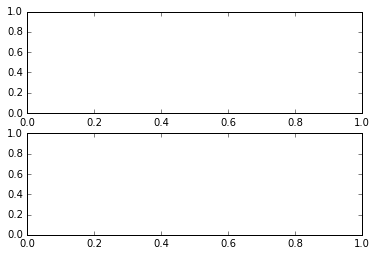

In [2]:
import numpy as np
import numpy.matlib
import math
import DC_Pickle as dcp
import matplotlib.pyplot as plt

train_scores = dcp.open_Pickle('../../data/pickles/seperate_origin/eventValue.pickle')
train_scores = train_scores[:15, :]

train_data = np.ones(15)*np.nan
idx_data = []

for i in range(train_scores.shape[1]):
    if not np.isnan(train_scores[:, i]).any():
        train_data = np.vstack((train_data, train_scores[:, i]))
        idx_data.append(i)
        
train_data = np.delete(train_data, (0), axis=0) # delete the first row including nan
train_data = train_data.T

[n,m]  = np.shape(train_data)               # dimension and number of training data

eta    = 0.05                               # learning rate
winit  = 1                                  # initialise weight

tmax   = 40000                              # max learning iteration

print(" - Dimension: {0}\n - Individuals: {1}".format(n, m))

fig_stats, axes_stats = plt.subplots(2,1)   # fig for the learning stats

## function for clustering with cost function return
def get_Cost(clusters_num, train):
    costs = []
    centroids = np.zeros((clusters_num, n, 10), dtype=float)
    cluster_idx = np.ones((10, m))*np.nan # 2X2 matrix to save all cluster index for each data
    
    for iter_i in range(10):
        ## dead unit handling by adding noise to inital weights
        W = np.ones((clusters_num, n))
        for i in range(clusters_num):
            index = np.random.choice(m)
            W[i] = train_data[:, index]        # Weight matrix (rows = output neurons, cols = input neurons)
        
        noise_to_W = np.random.rand(clusters_num, n) / 10       # average weight is 0.05
        W = W + noise_to_W
        
        normW = np.sqrt(np.diag(W.dot(W.T)))
        normW = normW.reshape(clusters_num,-1)            # reshape normW into a numpy 2d array
        W = W / normW                               # normalise using numpy broadcasting

        normTrain = np.sqrt(np.diag(np.dot(train.T, train)))
        normTrain = normTrain.reshape(m, -1)
        train = train/normTrain.T

        counter = np.zeros((1,clusters_num))              # counter for the winner neurons
        wCount = np.ones((1,tmax+1)) * 0.25         # running avg of the weight change over time
        alpha = 0.999

        yl = int(round(clusters_num/5))                   # counter for the rows of the subplot
        if clusters_num % 5 != 0:
            yl += 1

        for t in range(1,tmax):
            i = math.ceil(m * np.random.rand())-1   # get a randomly generated index in the input range
            x = train[:,i]                          # pick a training instance using the random index

            h = W.dot(x)/clusters_num                     # get output firing
            h = h.reshape((h.shape[0],-1))          # reshape h into a numpy 2d array

            ## add noise to output
            # xi = np.random.rand(clusters_num,1) / 200
            # k = np.argmax(h+xi)                     # get the index of the firing neuron
            k = np.argmax(h)                     # get the index of the firing neuron

            counter[0,k] += 1                       # increment counter for winner neuron

            dw = eta * (x.T - W[k,:])               # calculate the change in weights for the k-th output neuron

            wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # % weight change over time (running avg)

            W[k,:] = W[k,:] + dw                    # weights for k-th output are updated

            if wCount[0, t] < 0.0001: # if it learns sufficiently with learning rate below 0.0001
                break

        ##########################################
        ## save means of clusters into the 3X3 centroids matrix
        centroids[:, :, iter_i] = W

        ##########################################
        # cluster_idx : 2X2 matrix to save all cluster index for each data
        ##########################################
        ## get indices of clusters for each data
        for data in range(m): # check all data
            min_vals = []
            for weight in range(clusters_num): # compare all clusters for a data
                diff = W[weight, :] - train[:, data] # get difference between data and clusters
                min_vals.append(sum(np.square(diff))) # get square distance

            min_idx = np.argmin(min_vals) # get cluster index which has minimum distance
            cluster_idx[iter_i, data] = min_idx # assign the index to the cluster_idx array

        # assign True and False if data belongs to specific cluster.
        for i in range(clusters_num):
            cluster_map = cluster_idx[iter_i, :] == i

            # make True and False matrix (cluster) for mapping
            cluster = cluster_map
            for j in range(14):
                cluster = np.vstack((cluster, cluster_map))
            #print(np.shape(train[cluster].reshape(n, -1)))

            for k in range(clusters_num):
                clt = "cluster{0}".format(i+1)
                globals()[clt]=train[cluster].reshape(n, -1)
            #print("cluster{0}: ".format(i), np.shape(eval("cluster{0}".format(i))))

        ##########################################
        ## Get average cost function of 10 iterations
        diff_sum = [] # all differences of clusters
        for c in range(clusters_num):
            diff_vals = [] # difference for one cluster
            clt = "cluster{0}".format(c+1)
            [n2, m2] = np.shape(eval(clt))
            for data in range(m2):
                diff = np.square(eval(clt)[:, data] - W[c, :])
                diff_vals.append(np.sum(diff))

            diff_sum.append(np.sum(diff_vals))

        costs.append(np.sum(diff_sum))
        
        # average of weight changes in time
        axes_stats[0].clear()
        axes_stats[0].set_title("Weight change in time")
        axes_stats[0].semilogx(wCount[0, 2:t + 1], '-b', linewidth=2.0)     # range of 2:t+1 is 3 ~ t+1
        axes_stats[0].set_xlim([1, 3*10000])
        axes_stats[0].set_ylim([-0.001, 0.255])
        
        # plot the number of output neurons' firing
        axes_stats[1].clear()
        axes_stats[1].set_title("Ouput neurons' entire firing number")
        axes_stats[1].bar(np.arange(1, clusters_num+1), counter.T, align='center')
        # axes_stats[4].set_xticks(np.arange(1, digits + 1))              # set the x axis numbering
        axes_stats[1].relim()                                           # recompute axes_stats' data limit
        axes_stats[1].autoscale_view(True, True, True)                  # update axes_stats' axis using the new data limit
        
        #plt.tight_layout(pad=0.5)
        dcp.make_folders('../../Figs/Learning_State/origin_set/cluster{0}/'.format(clusters_num))
        fig_stats.savefig('../../Figs/Learning_State/origin_set/cluster{0}/iter{1}.png'.format(clusters_num, iter_i), dpi=100)

    return min(costs), centroids, cluster_idx

# Clustering checking cost with AIC & BIC & Elbow methods

In [ ]:
import time
import DC_Pickle as dcp
t0 = time.clock() # initial time

dcp.make_folders("../../data/pickles/clusters_test/")

dimension = 10
elbow = []
AIC = []
BIC = []

for clt in range(dimension):
    set_clt_filename = "../../data/pickles/clusters_test/centroid{0}.pickle".format(clt+1)
    set_idx_filename = "../../data/pickles/clusters_test/index{0}.pickle".format(clt+1)
    
    [cost, cent, idx] = get_Cost(clt+1, train_data) # return cost, centroid matrix, index matrix
    
    elbow.append(cost)
    AIC.append(cost + 2*clt*dimension)
    BIC.append(cost +  clt*math.log10(15)*dimension)
    
    #dcp.make_Pickle(cent, set_clt_filename, force=True)
    #dcp.make_Pickle(idx, set_idx_filename, force=True)
    print("iteration ", clt+1)

print("\n - process terminal (Run time:{0})".format(time.clock()-t0))

In [ ]:
dcp.make_folders("../../data/pickles/clusters_origin/costs/")
dcp.make_Pickle(elbow, "../../data/pickles/clusters_origin/costs/elbow.pickle")
dcp.make_Pickle(AIC, "../../data/pickles/clusters_origin/costs/AIC.pickle")
dcp.make_Pickle(BIC, "../../data/pickles/clusters_origin/costs/BIC.pickle")

### Plotting cost functions

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))                                                               
ax = fig.add_subplot(1,1,1) 

ax.grid(which='both')
                                   
ax.grid(which='major', alpha=0.5)

ax.plot(np.arange(clusters)+1, elbow, 'g-', label="Elbow")
ax.plot(np.arange(clusters)+1, AIC, 'r-', label="AIC")
ax.plot(np.arange(clusters)+1, BIC, 'b-', label="BIC")
ax.set_xlabel('k')
ax.set_ylabel('average cost')
ax.legend()
fig.savefig('../../Figs/AIC_BIC_Elbow.png', dpi=100)

### Plotting centroids

../../Figs/Centroids/Origin/ already present - Skipping pickling.


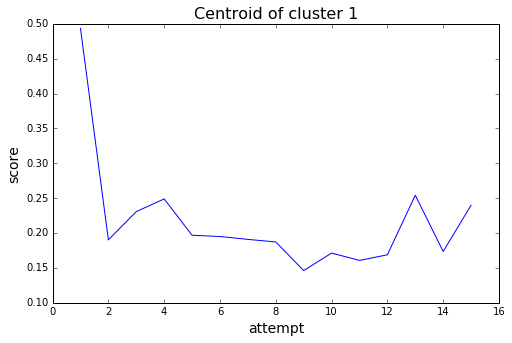

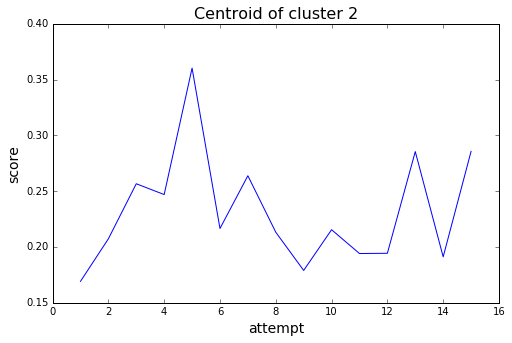

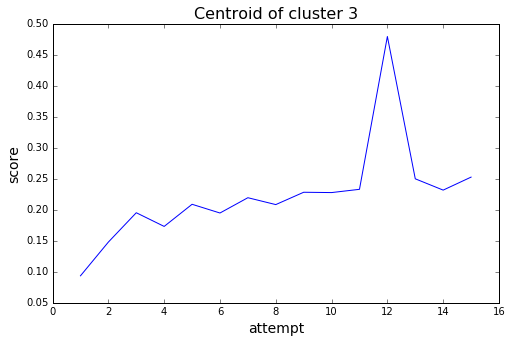

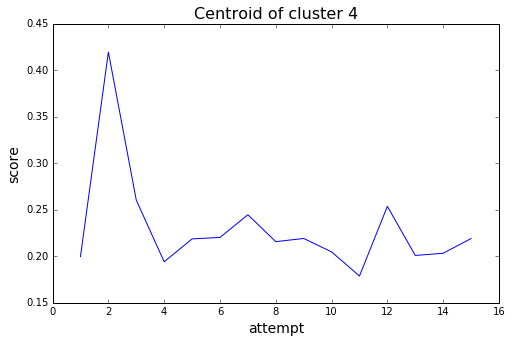

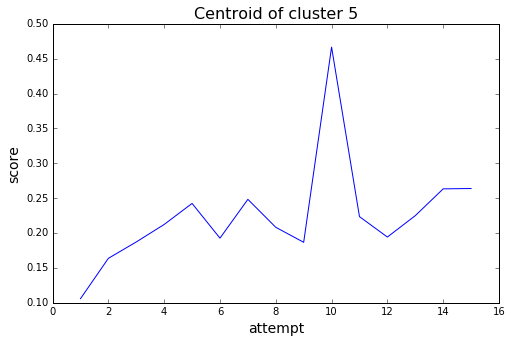

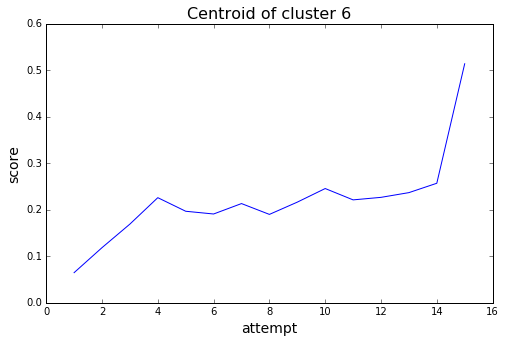

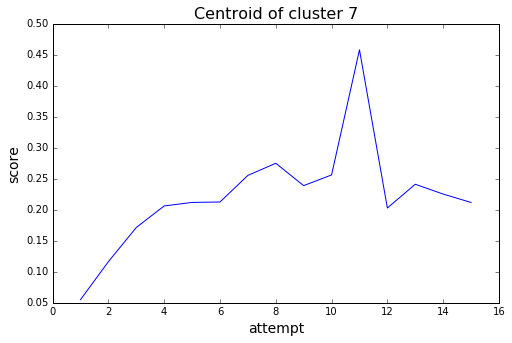

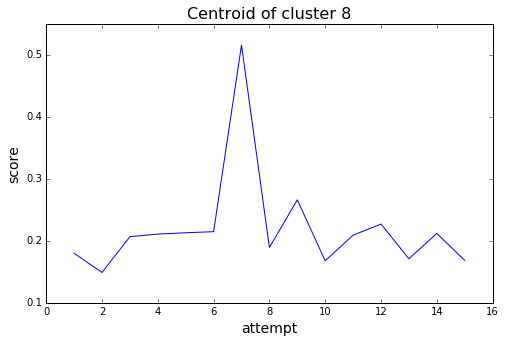

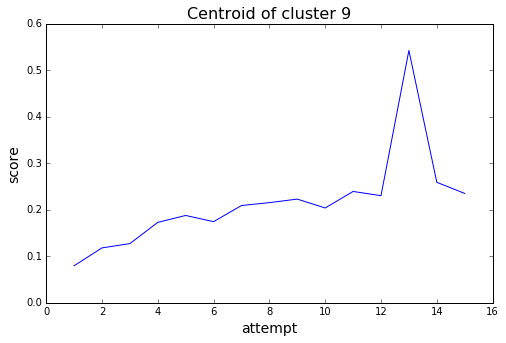

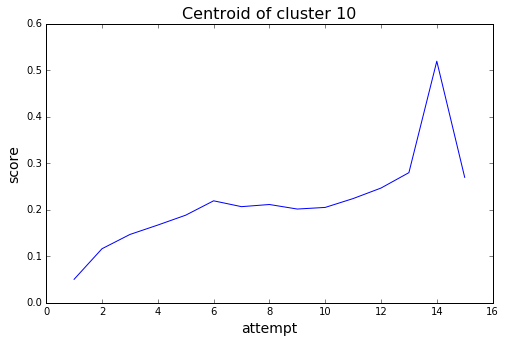

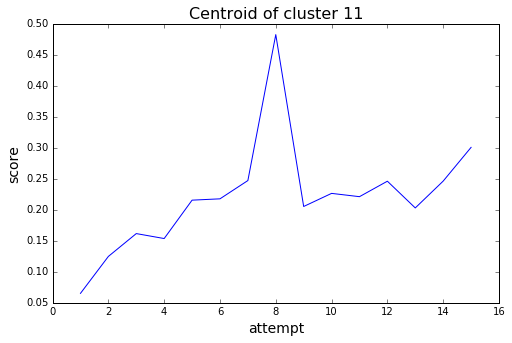

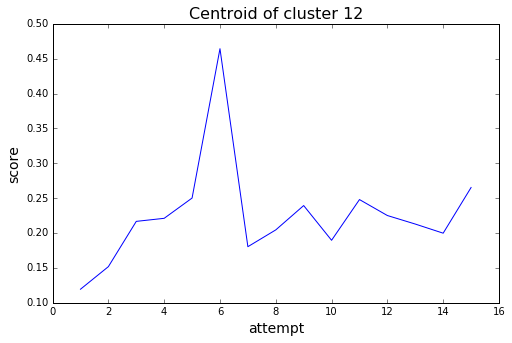

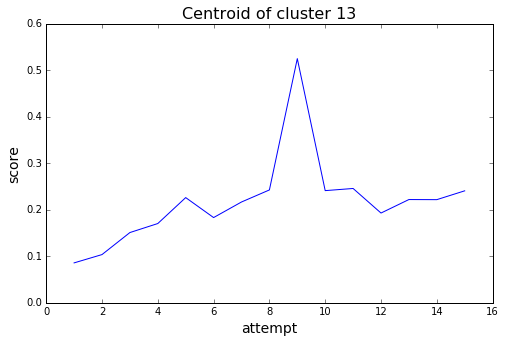

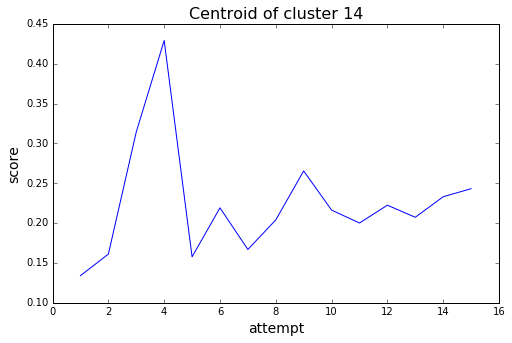

In [3]:
import matplotlib.pyplot as plt
import DC_Pickle as dcp
%matplotlib inline

dcp.make_folders("../../Figs/Centroids/Origin/")
clt_num = 14
attempts = np.arange(15)+1

centroids = dcp.open_Pickle("../../data/pickles/clusters_origin/centroids/centroid14.pickle")
indices = dcp.open_Pickle("../../data/pickles/clusters_origin/indices/index14.pickle")

centroids = centroids[:, :, 6]

for i in range(clt_num):
    idx = indices[6] == i
    ply = train_data[:, idx]*10e-5


    fig, ax = plt.subplots(1, 1, figsize=(8, 5))   # fig for the learning stats
    ax.plot(attempts, centroids[i, :])
    ax.set_title("Centroid of cluster {0}".format(i+1), fontsize=16)
    plt.xlabel('attempt', fontsize=14)
    plt.ylabel('score', fontsize=14)
    
    fig.savefig("../../Figs/Centroids/Origin/{0}".format(i+1))